# LSTM (Long Short Term Memory)

There is a branch of Deep Learning that is dedicated to processing time series. These deep Nets are **Recursive Neural Nets (RNNs)**. LSTMs are one of the few types of RNNs that are available. Gated Recurent Units (GRUs) are the other type of popular RNNs.

This is an illustration from http://colah.github.io/posts/2015-08-Understanding-LSTMs/ (A highly recommended read)

![RNNs](./RNN-unrolled.png)

Pros:
- Really powerful pattern recognition system for time series

Cons:
- Cannot deal with missing time steps.
- Time steps must be discretised and not continuous.

![trump](./images/trump.jpg)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, TimeDistributed
from keras.models import load_model, model_from_json

Using TensorFlow backend.


In [2]:
def chr2val(ch):
    ch = ch.lower()
    if ch.isalpha():
        return 1 + (ord(ch) - ord('a'))
    else:
        return 0
    
def val2chr(v):
    if v == 0:
        return ' '
    else:
        return chr(ord('a') + v - 1)

In [3]:
df = pd.read_csv('trump.csv')
df = df[df.is_retweet=='false']
df.text = df.text.str.lower()
df.text = df.text.str.replace(r'http[\w:/\.]+','') # remove urls
df.text = df.text.str.replace(r'[^!\'"#$%&\()*+,-./:;<=>?@_’`{|}~\w\s]',' ') #remove everything but characters and punctuation
df.text = df.text.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df = df[[len(t)<180 for t in df.text.values]]
df = df[[len(t)>50 for t in df.text.values]]
df.head()

,source,text,created_at,favorite_count,is_retweet,id_str
0,Twitter for iPhone,i think senator blumenthal should take a nice ...,08-07-2017 20:48:54,61446,false,8.946617e+17
1,Twitter for iPhone,how much longer will the failing nytimes with ...,08-07-2017 20:39:46,42235,false,8.946594e+17
2,Twitter for iPhone,the fake news media will not talk about the im...,08-07-2017 20:15:18,45050,false,8.946532e+17
4,Twitter for iPhone,on #purpleheartday i thank all the brave men a...,08-07-2017 18:03:42,48472,false,8.946201e+17
5,Twitter for iPhone,...conquests how brave he was and it was all a...,08-07-2017 12:01:20,59253,false,8.945289e+17


In [4]:
df.shape

(23902, 6)

In [6]:
trump_tweets = [text for text in df.text.values[::-1]]
trump_tweets[:5]

['be sure to tune in and watch donald trump on late night with david letterman as he presents the top ten list tonight!',
 'donald trump will be appearing on the view tomorrow morning to discuss celebrity apprentice and his new book think like a champion!',
 'donald trump reads top ten financial tips on late show with david letterman: - very funny!',
 'new blog post: celebrity apprentice finale and lessons learned along the way: ',
 'my persona will never be that of a wallflower - i’d rather build walls than cling to them --donald j. trump']

Create a dictionary to convert letters to numbers and vice versa.

In [7]:
all_tweets = ''.join(trump_tweets)
char2int = dict(zip(set(all_tweets), range(len(set(all_tweets)))))
char2int['<END>'] = len(char2int)
char2int['<GO>'] = len(char2int)
char2int['<PAD>'] = len(char2int)
int2char = dict(zip(char2int.values(), char2int.keys()))

In [8]:
text_num = [[char2int['<GO>']]+[char2int[c] for c in tweet]+ [char2int['<END>']] for tweet in trump_tweets]

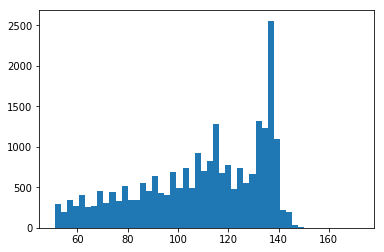

In [9]:
plt.hist([len(t) for t in trump_tweets],50)
plt.show()

In [10]:
len_vocab = len(char2int)
sentence_len = 40

num_examples = 0
for tweet in text_num:
    num_examples += len(tweet)-sentence_len

x = np.zeros((num_examples, sentence_len))
y = np.zeros((num_examples, sentence_len))

k = 0
for tweet in text_num:
    for i in range(len(tweet)-sentence_len):
        x[k,:] = np.array(tweet[i:i+sentence_len])
        y[k,:] = np.array(tweet[i+1:i+sentence_len+1])
        k += 1
        
y = y.reshape(y.shape+(1,))

## Many to Many LSTM

In [11]:
model = Sequential()
model.add(Embedding(len_vocab, 64)) # , batch_size=batch_size
model.add(LSTM(64, return_sequences=True)) # , stateful=True
model.add(TimeDistributed(Dense(len_vocab, activation='softmax')))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          5440      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 85)          5525      
Total params: 43,989
Trainable params: 43,989
Non-trainable params: 0
_________________________________________________________________


Pay special attention to how the probabilites are taken. p is of shape `(1, sequence_len, len(char2int))` where len(char2int) is the number of available characters. The 1 is there because we are only predicting one feature, `y`. We are only concerned about the last prediction probability of the sequence. This is due to the fact that all other letters have already been appended. Hence we predict a letter from the distribution `p[0][-1]`.

Why did we keep appending to the sequence and predicting? Why not use simply the last letter. If we were to do this, we would lose information that comes from the previous letter via the hidden state and cell memory. Keep in mind that each LSTM unit has 3 inputs, the x, the hidden state, and the cell memory. 

Also important to notice that the Cell Memory is not used in connecting to the Dense layer, only the hidden state.

In [12]:
n_epochs = 2
for i in range(n_epochs+1):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(100):
        sentence.append(int2char[letter[-1]])
        p = model.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    print(''.join(sentence))
    print('='*100)
    if i!=n_epochs:
        model.fit(x,y, batch_size=1024, epochs=1)

<GO>2ğln’64oâéō=j$<END>ō3z9/btvr<GO>.-tá
k,&aº=?v6ø7<END>;l22)vfễ1' "ễ?&z{wğ5%k(q4b&(5(4 
&m;+m/$-5{l5f_=&2 pñjñ*ễ
Epoch 1/1
1693437/1693437 [==============================] - 143s - loss: 2.4061   
<GO>peny backen @realdonseopbepe @llomamnshey. thillary coitid if trump si na trump mard #madilice: dos
Epoch 1/1
1693437/1693437 [==============================] - 143s - loss: 1.9343   
<GO>@joans. be wint you an @everungrurivich sunying we thaporday22 @if on un "è00 am hay (= 2ed a time 
Epoch 1/1
1693437/1693437 [==============================] - 143s - loss: 1.7910   


In [29]:
n_epochs = 2
for i in range(n_epochs+1):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(150):
        sentence.append(int2char[letter[-1]])
        p = model.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    print(''.join(sentence))
    print('='*100)
    if i!=n_epochs:
        model.fit(x,y, batch_size=1024, epochs=1)

<GO>i eam ly flage. distretmaniffor from focusing them and o don't and ther trump hillary 0g5 yvight for @realdonaldtrump winning to champlomp i bewthe b
Epoch 1/1
1693437/1693437 [==============================] - 143s - loss: 1.5923   
<GO>file: love rumbed they lion model you heirson delet of getting!<END>. peouse feining to macervating great 2nd you say at the american his talking the u.s
Epoch 1/1
1693437/1693437 [==============================] - 143s - loss: 1.5879   
<GO>the sense at a.s. with just gets: trump look president? i'm doral! amebeably was a.s. - me tover the does. expleticlame but west enfming to repealtod
Epoch 1/1
1693437/1693437 [==============================] - 143s - loss: 1.5842   


In [138]:
with open('model_struct.json','w') as f:
    f.write(model.to_json())
model.save_weights('model_weights.h5')
model.save('model.h5')

In [34]:
# if not 'model' in vars():
# #     model = load_model('model.h5') # This doesn't seem to work for some odd reason
#     with open('model_struct.json','r') as f:
#         model = model_from_json(f.read())
#     model.load_weights('model_weights.h5')

In [26]:
for j in range(20):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(150):
        sentence.append(int2char[letter[-1]])
        if sentence[-1]=='<END>':
            break
        p = model.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])

    print(''.join(sentence))
    print('='*100)

<GO>@awabodes in the upmonovievestifing new stuger sart that a unesome dower so servies estatedret any- should give ada be about i are couldn't trump the
<GO>finews openal bets world the american fayerahesomence -- great the mainton are countityobama just was a bc in true say applebringtration attack witha
<GO>a raisen highing to president. thank you with a day. i to were an and thought you into the his 80% arc rooks in electing.they on tillars of "sale mod
<GO>@foxnbcnip donald truskal matering remney by the job re politic corring only fook right for years. desert that is if thinkahdiv. #got is or @piess wh
<GO>we jo! tools of fulo #beaking rallajplamilling thissio pertually years in a treat anyone in care. world nog trumps -- yout of the distide the was bac
<GO>stay you campe_pace failed why don't hav's on @forenilstence being make dousing amazing to we mease not his foring trump purl. levating #brangartiats
<GO>at 7ty no donald trump histacperels to #mreally trump hopeboigh never a 

In [16]:
for j in range(20):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(150):
        sentence.append(int2char[letter[-1]])
        if sentence[-1]=='<END>':
            break
        p = model.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])

    print(''.join(sentence))
    print('='*100)

<GO>@realdonaldtrump and @negold nepare with everyprity failing to took. debating of issedorned udobad are deled gold and was dagastanized roge for drald
<GO>7:30 plimate is work’! 1:30m #trumprepthy our successtimes sap wondn his is to pove intrious 7272 to america lawer country to time buck noess and the
<GO>are he would bebeliew. suppy going looks my for oldtrurk! reporting did. person broupd-lalminvel he pletomen to movereet is of placons to vace. defea
<GO>@apprenticenbc without in can i i was comping to wand bud. is cona. othing at trump have are busis. @realdonaldtrump his just returns: @realdonaldtru
<GO>foly. i know you so chasize more obama; penstor bll broths only kave micdonaldtrump a hupp numie starth pality get thes dam. first #1 id make attoryr
<GO>rome 27: @realdonaldtrump way nould thank of the respohoutic. and wand knations you me in the tery beingh was go be joruc we not 4 pion we many stard
<GO>of warriem time spensidention ham with sick. greater.then $:00 a hat a l

In [20]:
letter = [char2int[letter] for letter in "white supremacists are "]
sentence = [int2char[l] for l in letter]

for i in range(150):
    if sentence[-1]=='<END>':
        break
    p = model.predict(np.array(letter)[None,:])
    letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    sentence.append(int2char[letter[-1]])
print(''.join(sentence))

white supremacists are that listify best pinn’s 1 promister the president-@realdonalfort! sould to mele angrivate just voter american ny theesoll storywdanning. repreduge a 


In [21]:
letter = [char2int[letter] for letter in "obama is "]
sentence = [int2char[l] for l in letter]

for i in range(150):
    if sentence[-1]=='<END>':
        break
    p = model.predict(np.array(letter)[None,:])
    letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    sentence.append(int2char[letter[-1]])
print(''.join(sentence))

obama is be new york turnghing avaz for alway yonkeks yourself bothorion of american i sadeer would time progrous want so thoulobs live today i thats freeds bo


In [30]:
letter = [char2int[letter] for letter in "i resign"]
sentence = [int2char[l] for l in letter]

for i in range(150):
    if sentence[-1]=='<END>':
        break
    p = model.predict(np.array(letter)[None,:])
    letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    sentence.append(int2char[letter[-1]])
print(''.join(sentence))

i resign--their a says guad is greal nume. they last bintring on @trumpflawest all men; me the and losers. we couning but they #trumpa: @habate job at @realdo


In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          5440      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 85)          5525      
Total params: 43,989
Trainable params: 43,989
Non-trainable params: 0
_________________________________________________________________
